## Create coco dataset

In [1]:
%pip install tf-models-official

import pandas as pd 
import json
import numpy as np
import datetime
import re
from sklearn import model_selection
import copy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv("../../dataset/preprocessed-datasets/preprocessed_metadata.csv")
df['bounding_boxes'] = df['bounding_boxes'].apply(json.loads)
df.head()

,Unnamed: 0,index,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,shape,margin,...,checksum,is_flipped,vertical_crop_pixels,horizontal_crop_pixels,width,height,preprocessed_original_image_path,num_masks,bounding_boxes,preprocessed_mass_all_mask_path
0,0,0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,...,8edd908901f92930776353c9ed140d95,False,480,1918,1918,3848,preprocessed/8edd908901f92930776353c9ed140d95.png,1,"[{'x': 270, 'y': 1942, 'width': 390, 'height':...",preprocessed/8edd908901f92930776353c9ed140d95_...
1,1,1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,...,d15f9840224eafd79870dc700c2e6cb1,False,480,2138,2138,3840,preprocessed/d15f9840224eafd79870dc700c2e6cb1.png,1,"[{'x': 271, 'y': 2500, 'width': 215, 'height':...",preprocessed/d15f9840224eafd79870dc700c2e6cb1_...
2,2,2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,...,17b97fe9529c1f9777fbf031fdfe7909,True,549,2277,2277,4393,preprocessed/17b97fe9529c1f9777fbf031fdfe7909.png,1,"[{'x': 1186, 'y': 2951, 'width': 382, 'height'...",preprocessed/17b97fe9529c1f9777fbf031fdfe7909_...
3,3,3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,...,39a6e98a61aa8e2c19b3136c48e1cc07,True,549,2151,2151,4393,preprocessed/39a6e98a61aa8e2c19b3136c48e1cc07.png,1,"[{'x': 1011, 'y': 2506, 'width': 381, 'height'...",preprocessed/39a6e98a61aa8e2c19b3136c48e1cc07_...
4,4,4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,...,baf98767e0ca955c78f41c147077435e,False,549,2113,2113,4393,preprocessed/baf98767e0ca955c78f41c147077435e.png,1,"[{'x': 694, 'y': 3255, 'width': 424, 'height':...",preprocessed/baf98767e0ca955c78f41c147077435e_...


In [8]:
train_df = df.query("dataset == 'train'")
test_df = df.query("dataset == 'test'")
train_ds_size = len(train_df)
test_ds_size = len(test_df)

In [18]:
%%bash

DATA_DIR='../../dataset/preprocessed-datasets/preprocessed'
TRAIN_ANNOTATION_FILE_DIR='../annotations/_train_annotations_1.coco.json'
OUTPUT_TFRECORD_TRAIN='../../dataset/preprocessed-datasets/tfrecords/train'

TEST_ANNOTATION_FILE_DIR='../annotations/_test_annotations.coco.json'
OUTPUT_TFRECORD_TEST='../../dataset/preprocessed-datasets/tfrecords/test'

python3 -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=${DATA_DIR} \
  --object_annotations_file=${TRAIN_ANNOTATION_FILE_DIR} \
  --output_file_prefix=$OUTPUT_TFRECORD_TRAIN \
  --num_shards=1

python3 -m official.vision.data.create_coco_tf_record --logtostderr \
  --image_dir=${DATA_DIR} \
  --object_annotations_file=$TEST_ANNOTATION_FILE_DIR \
  --output_file_prefix=$OUTPUT_TFRECORD_TEST \
  --num_shards=1

2023-05-22 11:04:22.607901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/anders/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
I0522 11:04:24.232438 140243229904896 create_coco_tf_record.py:502] writing to output path: ../../dataset/preprocessed-datasets/tfrecords/train
I0522 11:04:24.239467 140243229904896 create_coco_tf_record.py:374] Building bounding box index.
I0522 11:04:24.239794 140243229904896 create_coco_tf_record.py:385] 0 images are missing bboxes.
I0522 11:04:

# Create model

## Import required libraries

In [3]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen

import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2023-05-22 11:20:28.157724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 11:20:28.301184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 11:20:28.302275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 11:20:29.180936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/anders/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please mo

2.12.0


## Configure the Retinanet Resnet FPN COCO model

In [4]:
train_data_input_path = f'../../dataset/preprocessed-datasets/tfrecords/train-00000-of-00001.tfrecord'
test_data_input_path = f'../../dataset/preprocessed-datasets/tfrecords/test-00000-of-00001.tfrecord'
model_dir = f'../models/trained_model_resnet/'
export_dir = f'../models/exported_model_resnet/'

In [5]:
exp_config = exp_factory.get_exp_config('retinanet_resnetfpn_coco')

### Adjust the model and dataset configurations so that it works with custom dataset(in this case `BCCD`).

In [9]:
batch_size = 8
num_classes = 1

HEIGHT, WIDTH = 1024, 512
IMG_SIZE = [HEIGHT, WIDTH, 3]

# Backbone config.
exp_config.task.freeze_backbone = False
exp_config.task.annotation_file = ''

# Model config.
exp_config.task.model.input_size = IMG_SIZE
exp_config.task.model.num_classes = num_classes + 1
exp_config.task.model.detection_generator.tflite_post_processing.max_classes_per_detection = exp_config.task.model.num_classes

# Training data config.
exp_config.task.train_data.input_path = train_data_input_path
exp_config.task.train_data.dtype = 'float32'
exp_config.task.train_data.global_batch_size = batch_size
exp_config.task.train_data.parser.aug_scale_max = 1.8
exp_config.task.train_data.parser.aug_scale_min = 0.5
exp_config.task.train_data.parser.aug_rand_hflip = True

# Validation data config.
exp_config.task.validation_data.input_path = test_data_input_path
exp_config.task.validation_data.dtype = 'float32'
exp_config.task.validation_data.global_batch_size = batch_size

### Adjust the trainer configuration.

In [10]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'

epochs = 10
batches = train_ds_size // batch_size
train_steps = epochs * batches

exp_config.trainer.steps_per_loop = batches # steps_per_loop = num_of_training_examples // train_batch_size

exp_config.trainer.summary_interval = exp_config.trainer.steps_per_loop
exp_config.trainer.checkpoint_interval = exp_config.trainer.steps_per_loop
exp_config.trainer.validation_interval = exp_config.trainer.steps_per_loop
exp_config.trainer.validation_steps =  test_ds_size // batch_size # validation_steps = num_of_validation_examples // eval_batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = exp_config.trainer.steps_per_loop
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.001
exp_config.trainer.optimizer_config.learning_rate.end_learning_rate = 0.000001
exp_config.trainer.optimizer_config.warmup.linear.warmup_learning_rate = 0.001

exp_config.task.validation_data.parser.max_num_instances = exp_config.task.train_data.parser.max_num_instances

exp_config.task.train_data.shuffle_buffer_size = 512
exp_config.task.validation_data.shuffle_buffer_size = 1
# exp_config.task.export_config.output_normalized_coordinates = True

exp_config.trainer.best_checkpoint_eval_metric = "AP"
exp_config.trainer.best_checkpoint_export_subdir = "best_ckpt"

print(batches, exp_config.trainer.steps_per_loop)

Running on CPU is slow, so only train for a few steps.
153 153


### Print the modified configuration.

In [12]:
pp.pprint(exp_config.as_dict())

{   'runtime': {   'all_reduce_alg': None,
                   'batchnorm_spatial_persistent': False,
                   'dataset_num_private_threads': None,
                   'default_shard_dim': -1,
                   'distribution_strategy': 'mirrored',
                   'enable_xla': False,
                   'gpu_thread_mode': None,
                   'loss_scale': None,
                   'mixed_precision_dtype': 'bfloat16',
                   'num_cores_per_replica': 1,
                   'num_gpus': 0,
                   'num_packs': 1,
                   'per_gpu_thread_count': 0,
                   'run_eagerly': False,
                   'task_index': -1,
                   'tpu': None,
                   'tpu_enable_xla_dynamic_padder': None,
                   'worker_hosts': None},
    'task': {   'allow_image_summary': False,
                'annotation_file': '',
                'differential_privacy_config': None,
                'export_config': {   'cast_detection_c

### Set up the distribution strategy.

In [13]:
if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
    distribution_strategy = tf.distribute.MultiWorkerMirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
    tf.tpu.experimental.initialize_tpu_system()
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
    distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    print('Warning: this will be really slow.')
    distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

print('Done')

with distribution_strategy.scope():
    task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

Done


### Create category index dictionary to map the labels to coressponding label names.

In [14]:
category_index={
    1: {
        'id': 1,
        
        'name': 'Mass'
       },
}
tf_ex_decoder = TfExampleDecoder()

### Helper function for visualizing the results from TFRecords.
Use `visualize_boxes_and_labels_on_image_array` from `visualization_utils` to draw boudning boxes on the image.

In [15]:
def show_batch(raw_records, num_of_examples):
    plt.figure(figsize=(20, 20))
    use_normalized_coordinates=True
    min_score_thresh = 0.30
    for i, serialized_example in enumerate(raw_records):
        plt.subplot(1, 3, i + 1)
        decoded_tensors = tf_ex_decoder.decode(serialized_example)
        image = decoded_tensors['image'].numpy().astype('uint8')
        scores = np.ones(shape=(len(decoded_tensors['groundtruth_boxes'])))
        print(decoded_tensors['groundtruth_boxes'])
        visualization_utils.visualize_boxes_and_labels_on_image_array(
            image,
            decoded_tensors['groundtruth_boxes'].numpy(),
            decoded_tensors['groundtruth_classes'].numpy().astype('int'),
            scores,
            category_index=category_index,
            use_normalized_coordinates=use_normalized_coordinates,
            max_boxes_to_draw=200,
            min_score_thresh=min_score_thresh,
            agnostic_mode=False,
            instance_masks=None,
            line_thickness=4)

        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Image-{i+1}')
    plt.show()

2023-05-22 11:10:52.743824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:10:52.744181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


tf.Tensor([[0.38992378 0.3181818  0.46824723 0.4478703 ]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.6510417  0.12675397 0.7164062  0.22731525]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.6428834  0.43728423 0.6798455  0.52704257]], shape=(1, 4), dtype=float32)


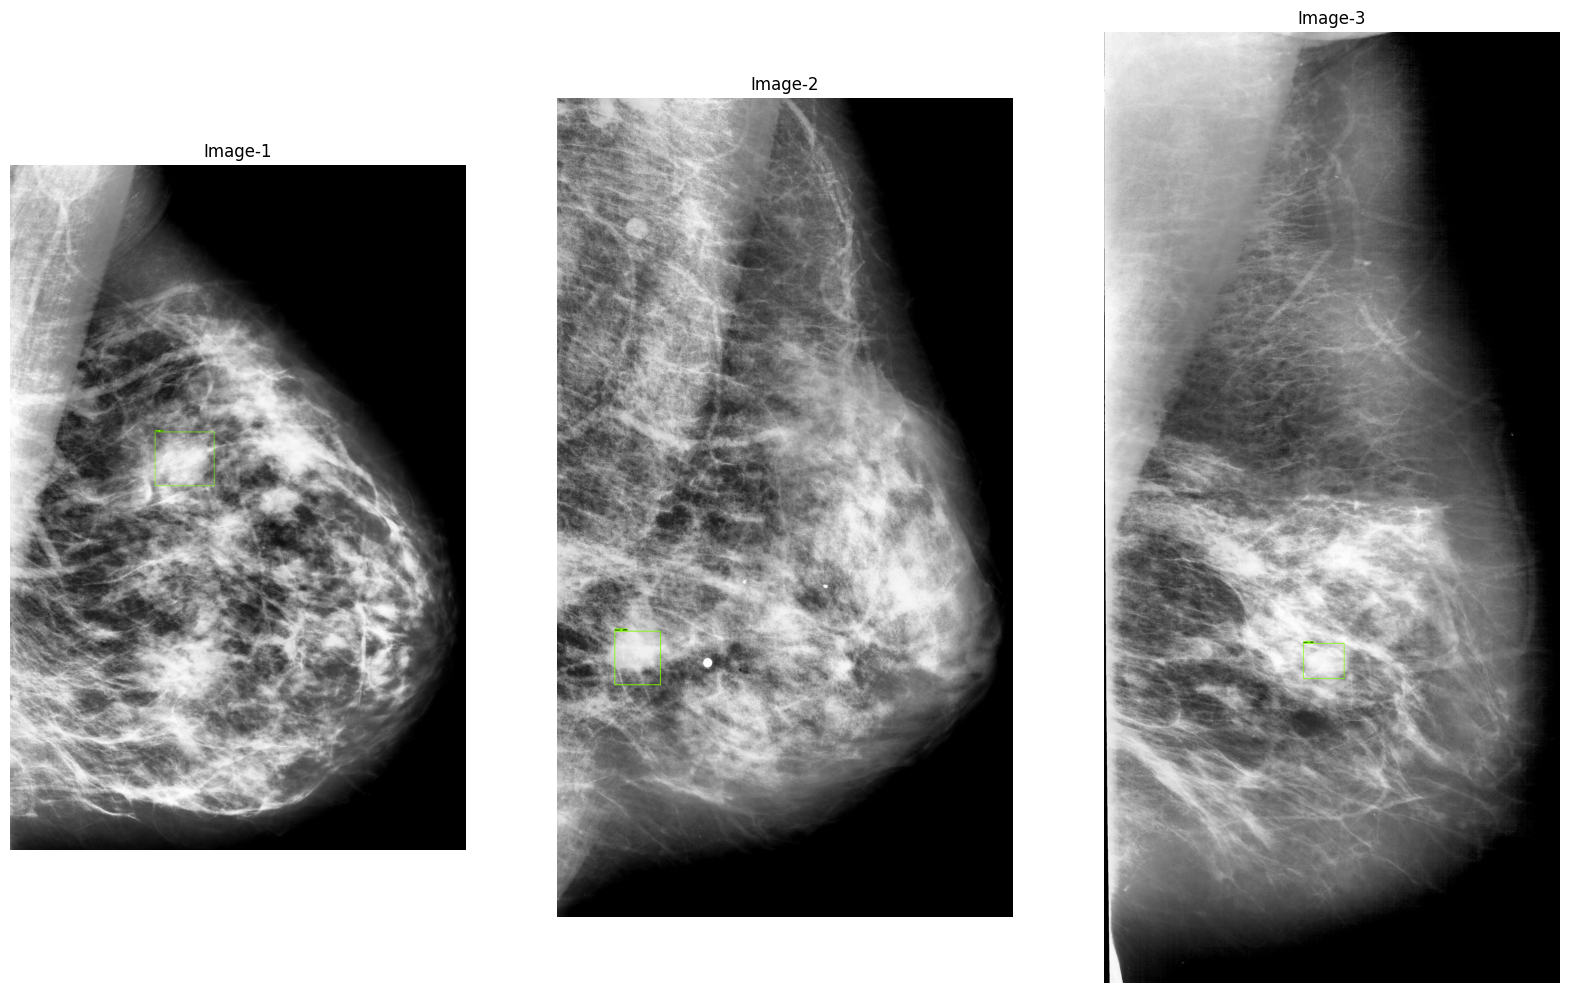

In [49]:
buffer_size = 20
num_of_examples = 3

raw_records = tf.data.TFRecordDataset(
    exp_config.task.train_data.input_path).shuffle(
        buffer_size=buffer_size).take(num_of_examples)
show_batch(raw_records, num_of_examples)

In [16]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=False)

2023-05-22 11:21:42.905238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'cond/range/strided_slice' with dtype int32
	 [[{{node cond/range/strided_slice}}]]


restoring or initializing model...


2023-05-22 11:21:46.200575: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


INFO:tensorflow:Customized initialization is done through the passed `init_fn`.


INFO:tensorflow:Customized initialization is done through the passed `init_fn`.


train | step:      0 | training until step 153...


2023-05-22 11:21:59.650174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:21:59.650451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:21:59.941638: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-22 11:21:59.942500: I tensorflow/core/common_runtime/executor.cc:1197] [/devi

train | step:    153 | steps/sec:    0.7 | output: 
    {'box_loss': 0.01588696,
     'cls_loss': 0.8498224,
     'learning_rate': 0.00097552827,
     'model_loss': 1.6441704,
     'total_loss': 2.0803134,
     'training_loss': 2.0803134}
saved checkpoint to ../models/trained_model_resnet/ckpt-153.
 eval | step:    153 | running 45 steps of evaluation...


2023-05-22 11:25:35.462874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:25:35.463071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:25:35.749702: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-22 11:25:35.750067: I tensorflow/core/common_runtime/executor.cc:1197] [/devi

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000


2023-05-22 11:29:47.919382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:29:47.919795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:29:48.271687: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-22 11:29:48.272040: I tensorflow/core/common_runtime/executor.cc:1197] [/devi

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.085
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000


2023-05-22 11:34:00.134542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:34:00.135013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:34:00.505146: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-22 11:34:00.505500: I tensorflow/core/common_runtime/executor.cc:1197] [/devi

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.080
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000


2023-05-22 11:38:10.193972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:38:10.194176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:38:10.541317: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-22 11:38:10.541686: I tensorflow/core/common_runtime/executor.cc:1197] [/devi

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000


2023-05-22 11:42:10.417180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:42:10.417399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:42:10.772346: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-22 11:42:10.772787: I tensorflow/core/common_runtime/executor.cc:1197] [/devi

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.067
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000


2023-05-22 11:46:01.270231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:46:01.270459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-22 11:46:01.626870: W tensorflow/core/framework/dataset.cc:807] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2023-05-22 11:46:01.627254: I tensorflow/core/common_runtime/executor.cc:1197] [/devi

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.218
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.218
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000


KeyboardInterrupt: 

: 

## Saving and exporting the trained model.

In [39]:
export_saved_model_lib.export_inference_graph(
    input_type='image_tensor',
    batch_size=1,
    input_image_size=[HEIGHT, WIDTH],
    params=exp_config,
    checkpoint_path=(model_dir + "/best_ckpt"),
    export_dir=export_dir)

## Inference from trained model

In [40]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

### Visualize test data.

tf.Tensor([[0.6725888  0.08974359 0.70812184 0.14387465]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.6761745  0.07492796 0.71308726 0.13976945]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.3112195  0.21414538 0.3990244  0.37721023]], shape=(1, 4), dtype=float32)


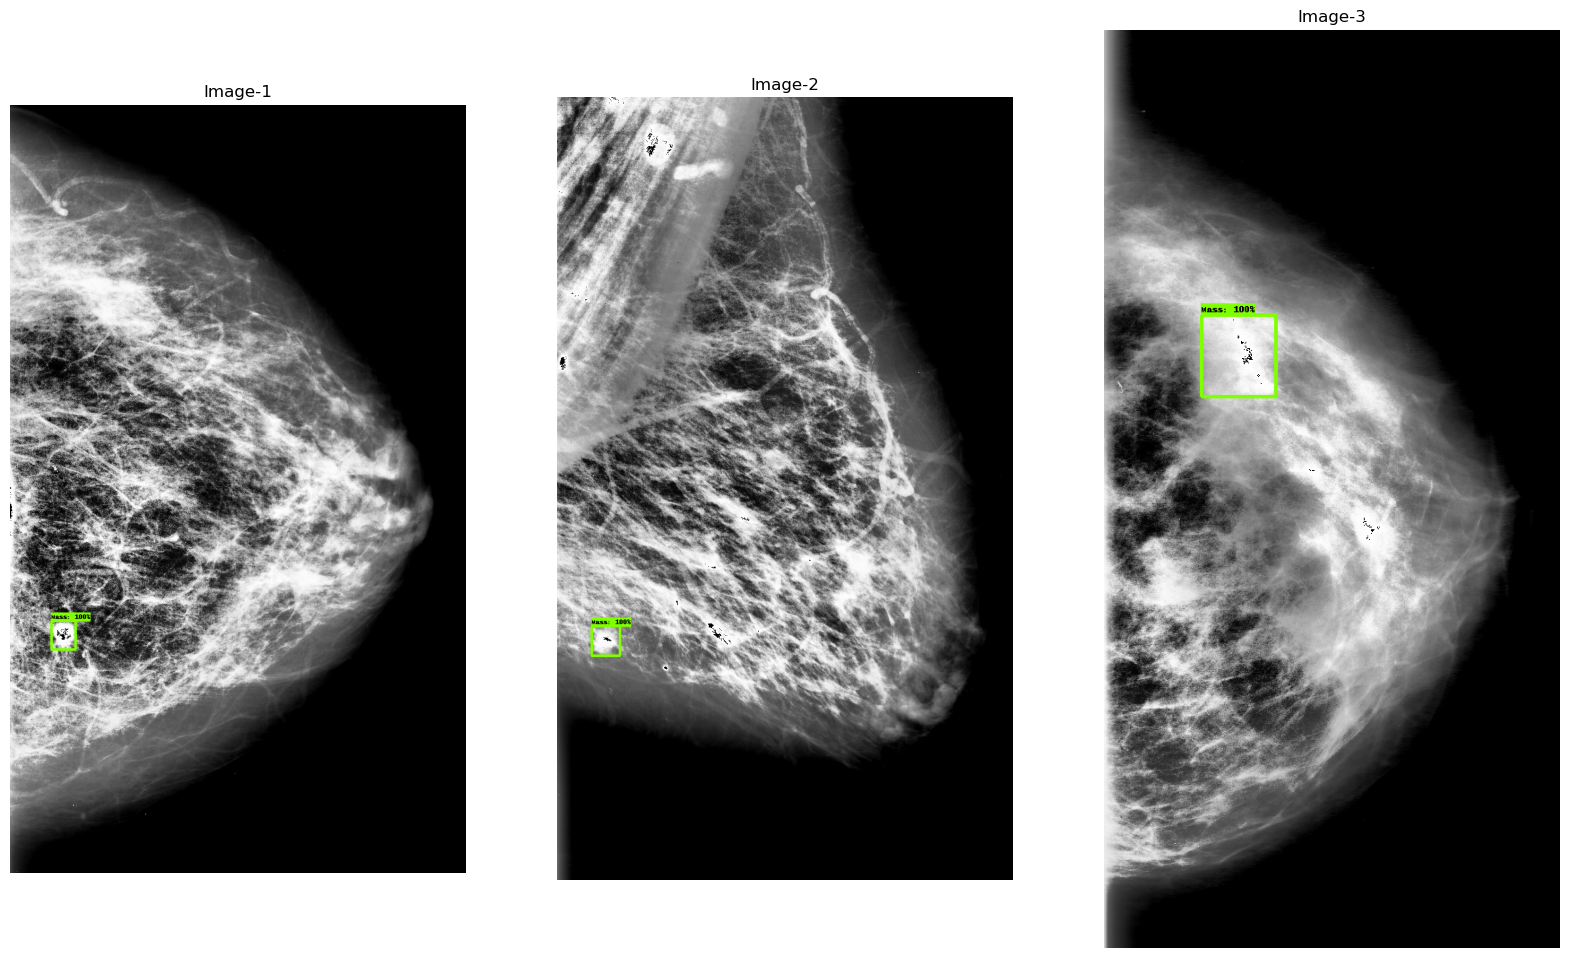

In [41]:
num_of_examples = 3

test_ds = tf.data.TFRecordDataset(test_data_input_path).take(num_of_examples)
show_batch(test_ds, num_of_examples)

### Importing SavedModel.

In [42]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

### Visualize predictions.

tf.Tensor([[0.6725888  0.08974359 0.70812184 0.14387465]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.6761745  0.07492796 0.71308726 0.13976945]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.3112195  0.21414538 0.3990244  0.37721023]], shape=(1, 4), dtype=float32)


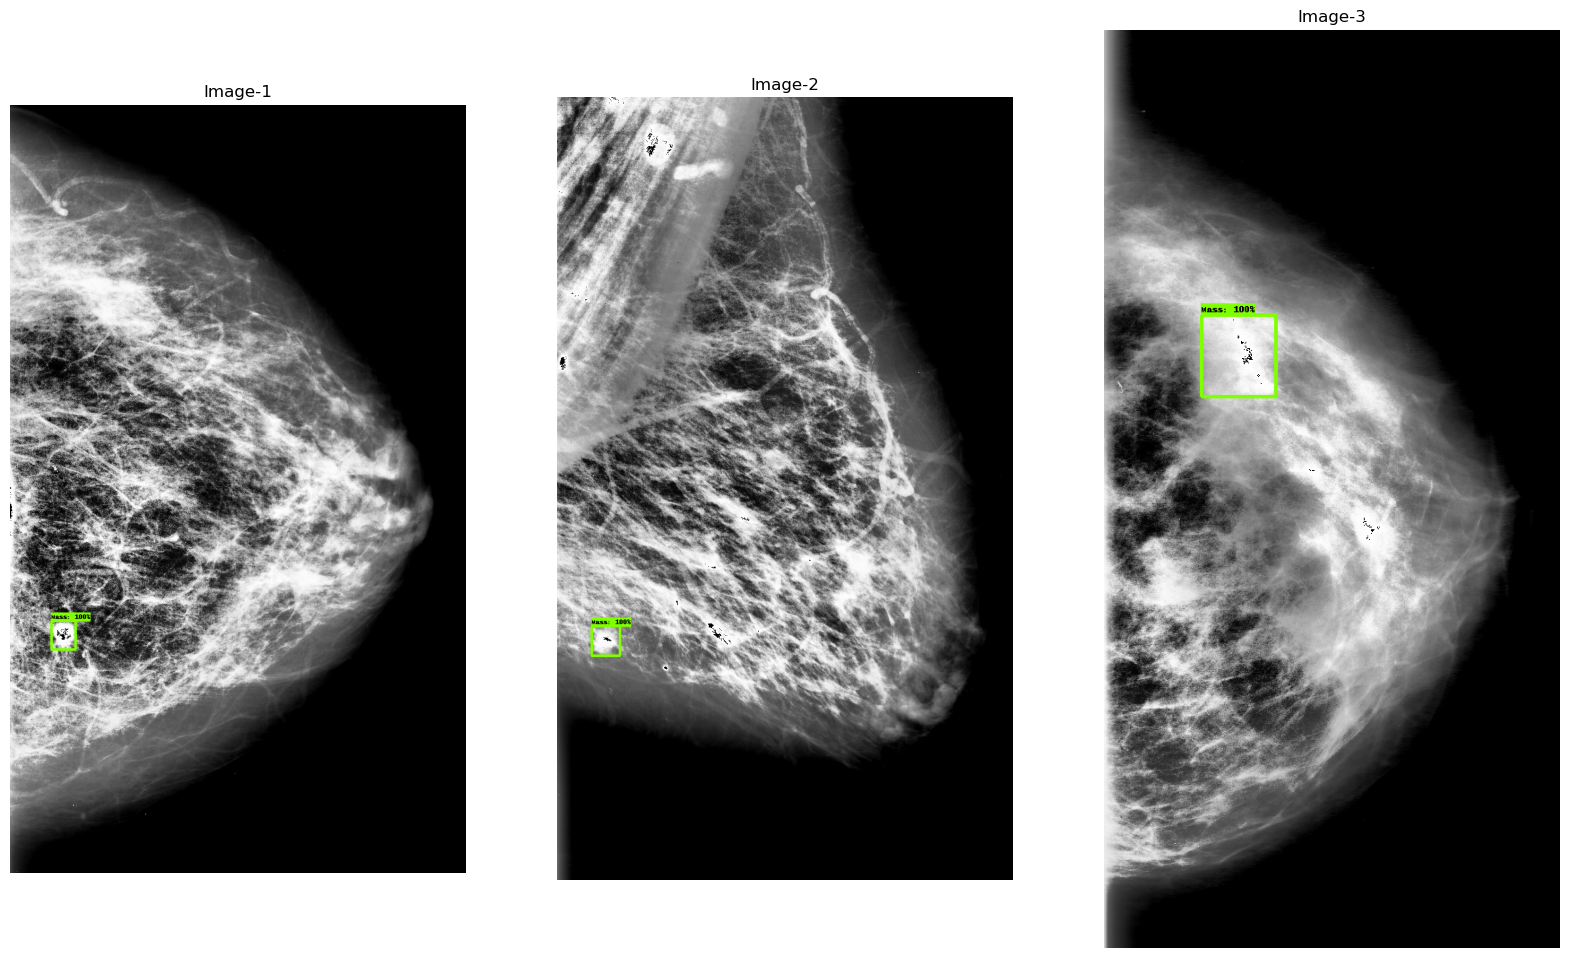

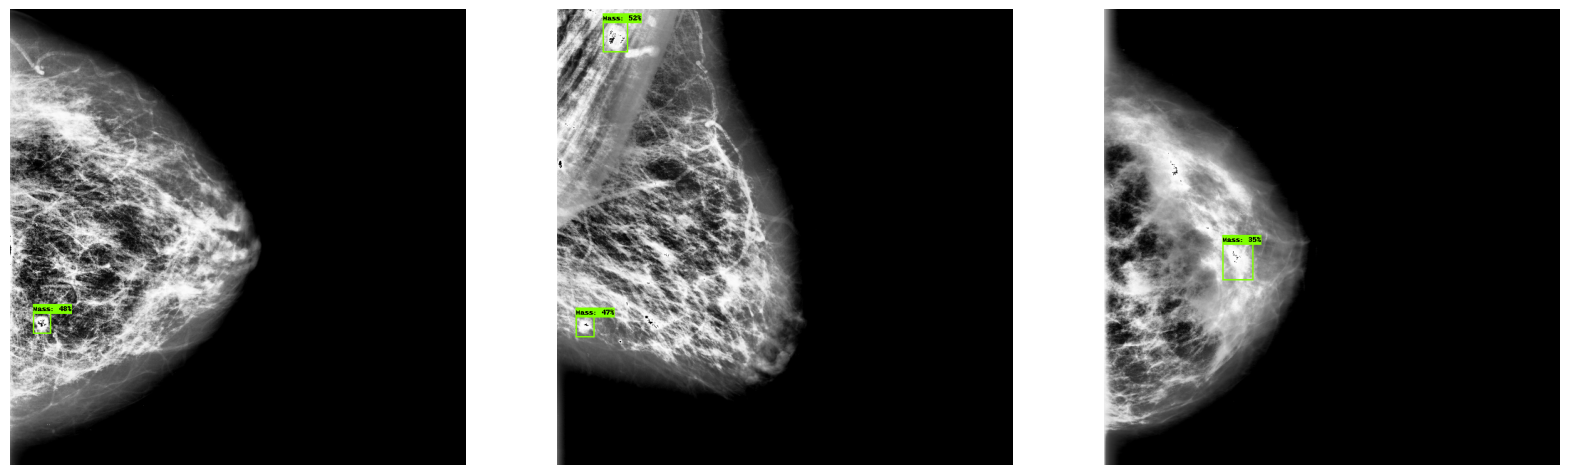

In [43]:
num_of_examples = 3

test_ds = tf.data.TFRecordDataset(test_data_input_path).take(num_of_examples)
show_batch(test_ds, num_of_examples)

input_image_size = (HEIGHT, WIDTH)
plt.figure(figsize=(20, 20))
min_score_thresh = 0.3 # Change minimum score for threshold to see all bounding boxes confidences.

for i, serialized_example in enumerate(test_ds):
    plt.subplot(1, 3, i+1)
    decoded_tensors = tf_ex_decoder.decode(serialized_example)
    image = build_inputs_for_object_detection(decoded_tensors['image'], input_image_size)
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, dtype = tf.uint8)
    image_np = image[0].numpy()
    result = model_fn(image)
    
    visualization_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        result['detection_boxes'][0].numpy(),
        result['detection_classes'][0].numpy().astype(int),
        result['detection_scores'][0].numpy(),
        category_index=category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=5,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=2)
    plt.imshow(image_np)
    plt.axis('off')

plt.show()